# Lab 3 Project (Titanic)
Jason Ballard
31 March 2025

Import the external Python libraries used (e.g., pandas, numpy, matplotlib, seaborn, sklearn and more).

## Section 1. Import and Inspect the Data

In [1]:
# all imports get moved to the top - import each only once

import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np


In [2]:
# Load Titanic dataset
df = sns.load_dataset('titanic')

features = list(df.columns)
print(features)
print(len(features))
# Understand the data
print(df.info())       # See column types and missing values
print(df.head(3))      # Peek at the structure
print(df.describe())   # Summary stats for numerical columns

['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2)

In [3]:
# titanic.info()
# print(titanic.head(10))
# titanic.isnull().sum()
# print(titanic.describe())
# print(titanic.corr(numeric_only=True))

# Section 2. Data Exploration and Preparation

In [4]:
# attributes = ['age', 'fare', 'pclass']
# scatter_matrix(titanic[attributes], figsize=(10, 10))

In [5]:
# plt.scatter(titanic['age'], titanic['fare'], c=titanic['sex'].apply(lambda x: 0 if x == 'male' else 1))
# plt.xlabel('Age')
# plt.ylabel('Fare')
# plt.title('Age vs Fare by Gender')
# plt.show()

In [6]:
# #Create a histogram of age:

# sns.histplot(titanic['age'], kde=True)
# plt.title('Age Distribution')
# plt.show()

In [7]:
# #Create a count plot for class and survival:

# sns.countplot(x='class', hue='survived', data=titanic)
# plt.title('Class Distribution by Survival')
# plt.show()

<!-- ### Reflection 2.1:

1. What patterns or anomalies do you notice? Young to middle age passengers, majority found in third class
2. Do any features stand out as potential predictors? the deck location or fare price
3. Are there any visible class imbalances? There are huge class imbalances. Majority of the passengers where younger families traveling to the USA -->

## 2.1 Handle Missing Values and Clean Data

In [8]:
# Fill missing 'embark_town' values with the most common value (mode)
df['embark_town'] = df['embark_town'].fillna(df['embark_town'].mode()[0])  # Fill with mode (most frequent)

# Fill missing 'sex' values with 'unknown' 
df['sex'] = df['sex'].fillna('unknown')  # Fill missing 'sex' with 'unknown'
# Convert 'sex' to numeric: male = 0, female = 1
df['sex'] = df['sex'].map({'male': 0, 'female': 1, 'unknown': -1})  

## 2.2 Feature Engineering

In [9]:
# Preprocessing: Fill missing values and create new features
df['family_size'] = df['sibsp'] + df['parch'] + 1
df['age'] = df['age'].fillna(df['age'].median())
df['embark_town'] = df['embark_town'].fillna(df['embark_town'].mode()[0])
df['sex'] = df['sex'].map({'male': 0, 'female': 1, 'unknown': -1})

label_encoder = LabelEncoder()
df['embark_town_encoded'] = label_encoder.fit_transform(df['embark_town'])

<!-- ### Reflection 2.3

1. Why might family size be a useful feature for predicting survival? famil;y size is a good prediction of survivalbility for the female and younger children of the families
2. Why convert categorical data to numeric?  the conversion allows computations to be run on the data. -->

# Section 3. Feature Selection and Justification

- Select two or more input features (numerical for regression, numerical and/or categorical for classification)
- Use 'Survived' as the target

First:
- input features: alone
- target: survived

Second:
- input features - embark_town
- target: survived

Third:
- input features -  age and family_size (embark_town)
- target: survived
- Justify your selection with reasoning.

## 3.1 Choose features and target

In [10]:
# Define the available features and target
features = ['alone', 'age', 'family_size', 'embark_town_encoded', 'sex']
target = 'survived'

## 3.2 Define X (features) and y (target)
- Assign input features to X a pandas DataFrame with 1 or more input features
- Assign target variable to y (as applicable) - a pandas Series with a single target feature
- Again - use comments to run a single case at a time

- The follow starts with only the statements needed for case 1. 
- Double brackets [[ ]]  makes a 2D DataFrame
- Single brackets [ ]  make a 1D Series

In [11]:
def select_case(case_number, df):
    if case_number == 1:
        feature_list = ['alone']
    elif case_number == 2:
        feature_list = ['embark_town_encoded']
    elif case_number == 3:
        feature_list = ['age', 'family_size', 'embark_town_encoded']
    else:
        raise ValueError("Invalid case number.")

    X = df[feature_list].dropna()
    y = df.loc[X.index, 'survived']
    return X, y, feature_list

### 3.3 Select and run a Specific Case (loop)

In [12]:
for case in [1, 2, 3]:
    X, y, features = select_case(case, df)
    print(f"Running Case {case} with features: {features}")

Running Case 1 with features: ['alone']
Running Case 2 with features: ['embark_town_encoded']
Running Case 3 with features: ['age', 'family_size', 'embark_town_encoded']


### 3.4 Eval Features 
Plot correlations, value counts, or feature distributions

Help to justify why the features were selected (especially for reports)

survived               1.000000
family_size            0.016639
age                   -0.064910
embark_town_encoded   -0.167675
Name: survived, dtype: float64


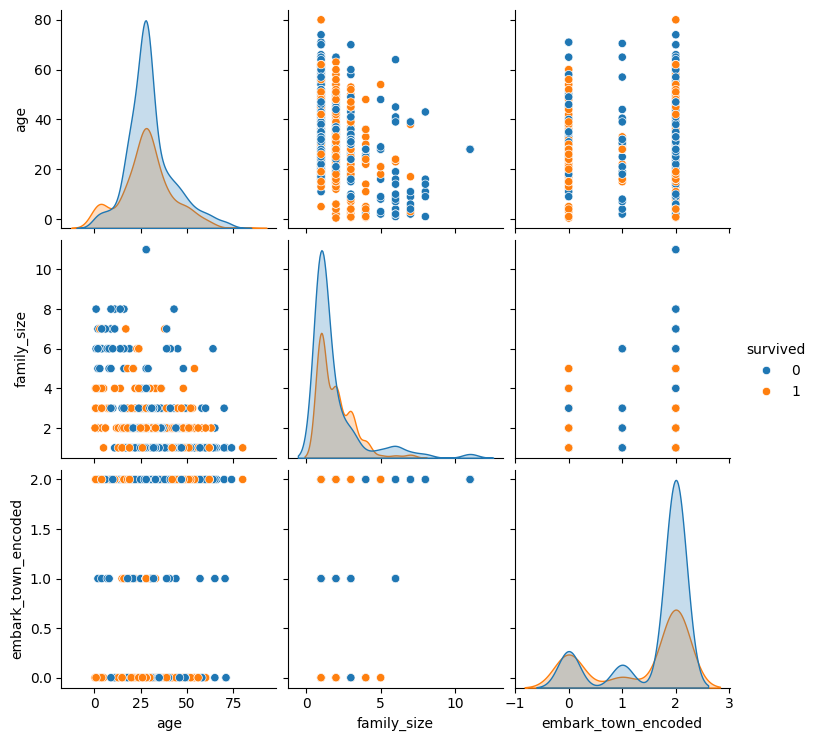

In [13]:
# Correlation of numerical features with 'survived'
print(df[features + ['survived']].corr()['survived'].sort_values(ascending=False))

# Visualize feature distribution
sns.pairplot(df[features + ['survived']], hue='survived')
plt.show()

### Reflection 3:

1. Why are these features selected? **the features selected provide the most tell of survivability**
2. Are there any features that are likely to be highly predictive of survival? **Yes age and class**

# Section 4. Train a Classification Model (Decision Tree)

## 4.1 Basic Train/Test split 

In [14]:
# def stratified_split(X, y, test_size=0.2, random_state=42):
#     splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
#     for train_idx, test_idx in splitter.split(X, y):
#         return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    
#     X_train, X_test, y_train, y_test = stratified_split(X, y)
#     print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
#     return X_train, X_test, y_train, y_test

In [15]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_indices, test_indices in splitter.split(X, y):
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]


## 4.2 Stratified Train/Test split

In [16]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

## 4.3 Compare Results


In [17]:
print("Original Class Distribution:\n", y.value_counts(normalize=True))
print("Train Set Class Distribution:\n", y_train.value_counts(normalize=True))
print("Test Set Class Distribution:\n", y_test.value_counts(normalize=True))


Original Class Distribution:
 survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64
Train Set Class Distribution:
 survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64
Test Set Class Distribution:
 survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


### 4.4 Eval the predictions

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72       110
           1       0.55      0.57      0.56        69

    accuracy                           0.65       179
   macro avg       0.64      0.64      0.64       179
weighted avg       0.66      0.65      0.65       179

Confusion Matrix:
 [[78 32]
 [30 39]]
Accuracy: 0.6536312849162011


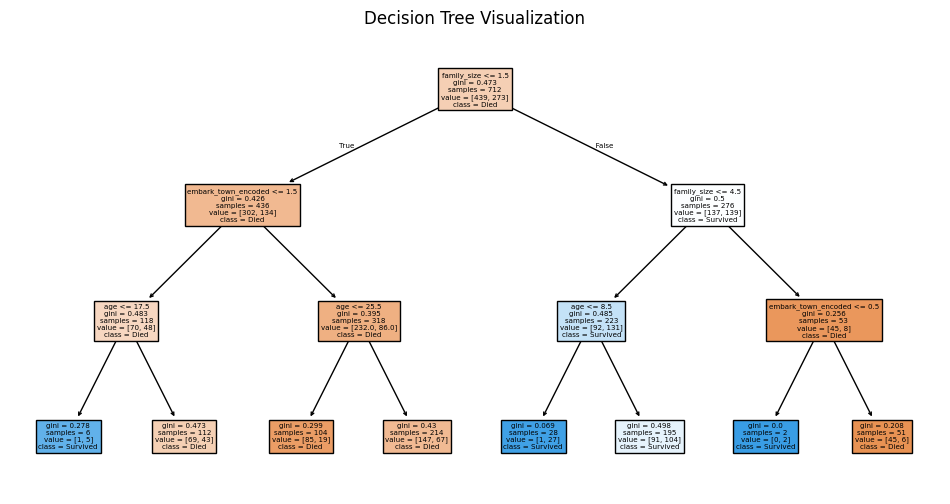

In [18]:
y_pred = tree_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


plt.figure(figsize=(12, 6))
plot_tree(tree_model, feature_names=X.columns, class_names=['Died', 'Survived'], filled=True)
plt.title('Decision Tree Visualization')
plt.show()


### Reflection 4:

1. Why might stratification improve model performance? **This ensures that the data is equallly representivate across the whole data set.**
2. How close are the training and test distributions to the original dataset? **identical**
3. Which split method produced better class balance? **I am not sure because th enumbers are so close**

## Section 5. Compare Alternative Models (SVC, NN) 

In a Support Vector Machine, the kernel function defines how the algorithm transforms data to find a hyperplane that separates the classes. If the data is not linearly separable, changing the kernel can help the model find a better decision boundary.

SVC Kernel: Common Types

RBF (Radial Basis Function) – Most commonly used; handles non-linear data well (default)
Linear – Best for linearly separable data (straight line separation)
Polynomial – Useful when the data follows a curved pattern
Sigmoid – Similar to a neural network activation function; less common
Commenting the options in and out in the code can be helpful. The analyst decides which to use based on their understanding of the results. 

In [19]:
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
for kernel in kernels:
    model = SVC(kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"SVC Kernel: {kernel} | Accuracy: {acc:.4f}")


SVC Kernel: rbf | Accuracy: 0.6313
SVC Kernel: linear | Accuracy: 0.6648
SVC Kernel: poly | Accuracy: 0.6145
SVC Kernel: sigmoid | Accuracy: 0.5531


In [20]:
# # RBF Kernel (default) - same as calling SVC()
# svc_model = SVC(kernel='rbf')
# svc_model.fit(X_train, y_train)

# # Linear Kernel
# svc_model = SVC(kernel='linear')
# svc_model.fit(X_train, y_train)

# # Polynomial Kernel (e.g., with degree=3)
# svc_model = SVC(kernel='poly', degree=3)
# svc_model.fit(X_train, y_train)

# # Sigmoid Kernel
# svc_model = SVC(kernel='sigmoid')
# svc_model.fit(X_train, y_train)

### 5.1 Train and Evaluate Model (SVC)

In [21]:
# Custom Kernel (e.g., using a callable function)
svc_model = SVC()
svc_model.fit(X_train, y_train)

y_pred_svc = svc_model.predict(X_test)

print("Results for SVC on test data:")
print(classification_report(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))
print("Accuracy:", accuracy_score(y_test, y_pred_svc))

Results for SVC on test data:
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
weighted avg       0.66      0.63      0.52       179

[[108   2]
 [ 64   5]]
Accuracy: 0.6312849162011173


### 5.1A  Dynamic plot- 

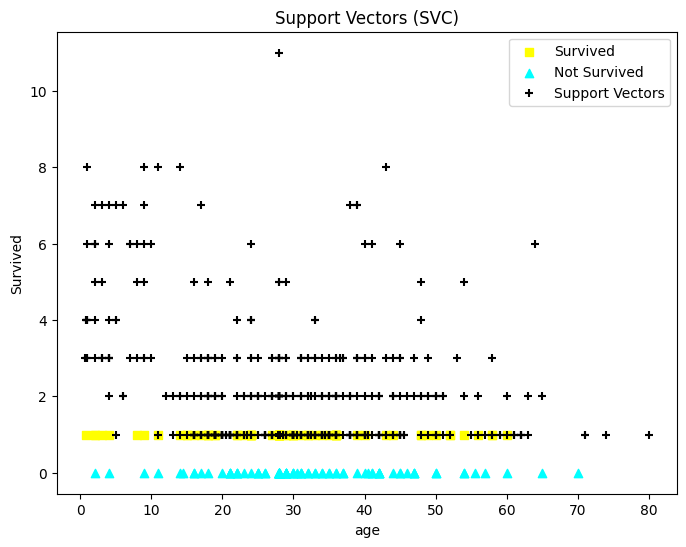

In [22]:
plot_feature = X.columns[0]  # Dynamically pick the first feature

survived_vals = X_test.loc[y_test == 1, plot_feature]
not_survived_vals = X_test.loc[y_test == 0, plot_feature]

plt.figure(figsize=(8, 6))
plt.scatter(survived_vals, y_test[y_test == 1], c='yellow', marker='s', label='Survived')
plt.scatter(not_survived_vals, y_test[y_test == 0], c='cyan', marker='^', label='Not Survived')

if hasattr(svc_model, 'support_vectors_'):
    support_x = svc_model.support_vectors_[:, 0]
    support_y = svc_model.support_vectors_[:, 1] if svc_model.support_vectors_.shape[1] > 1 else None
    if support_y is not None:
        plt.scatter(support_x, support_y, c='black', marker='+', label='Support Vectors')
    else:
        plt.scatter(support_x, [0]*len(support_x), c='black', marker='+', label='Support Vectors')

plt.xlabel(plot_feature)
plt.ylabel('Survived')
plt.title('Support Vectors (SVC)')
plt.legend()
plt.show()


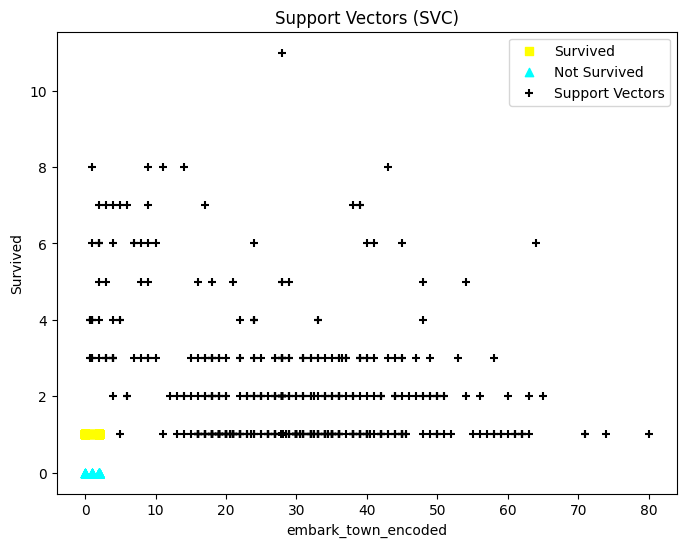

In [23]:
# Create data for charting - input target yes and input target no
survived_alone = X_test.loc[y_test == 1, 'embark_town_encoded']
not_survived_alone = X_test.loc[y_test == 0, 'embark_town_encoded']


# Create scatter plot for survived and not survived
plt.figure(figsize=(8, 6))
plt.scatter(survived_alone, y_test.loc[y_test == 1], c='yellow', marker='s', label='Survived')
plt.scatter(not_survived_alone, y_test.loc[y_test == 0], c='cyan', marker='^', label='Not Survived')

# Add support vectors (if available)
if hasattr(svc_model, 'support_vectors_'):
    support_x = svc_model.support_vectors_[:, 0]  # First feature (alone)
    support_y = svc_model.support_vectors_[:, 1] if svc_model.support_vectors_.shape[1] > 1 else None
    
    # Plot support vectors
    if support_y is not None:
        plt.scatter(support_x, support_y, c='black', marker='+', label='Support Vectors')
    else:
        plt.scatter(support_x, [0] * len(support_x), c='black', marker='+', label='Support Vectors')

# Add labels and legend
plt.xlabel('embark_town_encoded')
plt.ylabel('Survived')
plt.legend()
plt.title('Support Vectors (SVC)')
plt.show()